### In this script, DBN is run on the combined sessions, combined for each condition

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [74]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - find social gaze time point

In [75]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_Anipose import find_socialgaze_timepoint_Anipose
from ana_functions.find_socialgaze_timepoint_Anipose_2 import find_socialgaze_timepoint_Anipose_2

### function - define time point of behavioral events

In [76]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_Anipose import bhv_events_timepoint_Anipose

### function - plot behavioral events

In [77]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.tracking_video_Anipose_events_demo import tracking_video_Anipose_events_demo
from ana_functions.plot_continuous_bhv_var import plot_continuous_bhv_var
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - interval between all behavioral events

In [78]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - Alec's methods

In [79]:
from ana_functions.train_DBN_alec import train_DBN_alec
from ana_functions.train_DBN_alec import train_DBN_alec_create_df_only
from ana_functions.train_DBN_alec import train_DBN_alec_training_only
from ana_functions.train_DBN_alec import graph_to_matrix
from ana_functions.train_DBN_alec import get_weighted_dags
from ana_functions.train_DBN_alec import get_significant_edges
from ana_functions.train_DBN_alec import threshold_edges
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [81]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/12 # 15 degree
# angle_thres = np.pi/4 # 45 degree
# angle_thres = np.pi/6 # 30 degree
angle_thres_name = '15'

merge_campairs = ['_Anipose'] # "_Anipose": this script is only for Anipose 3d reconstruction of camera 1,2,3 

with_tubelever = 1 # 1: consider the location of tubes and levers, only works if using Anipose 3d (or single camera)

# get the fps of the analyzed video
fps = 30

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20220912","20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                     ]
        session_start_times = [ 
                                18.10,  0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 1:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230213","20230214","20230216",
                      "20230228","20230302","20230303",
                      "20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615"
                   ]
        session_start_times = [ 
                                 0.00,  0.00, 48.00, 
                                23.00, 28.50, 34.00, 
                                25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
#    
# dates_list = ["20221128"]
# session_start_times = [1.00] # in second

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()    
    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']

# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# where to save the demo video
withboxCorner = 1
video_file_dir = data_saved_folder+'/example_videos_Anipose_bhv_demo/'+animal1_filename+'_'+animal2_filename
if not os.path.exists(video_file_dir):
    os.makedirs(video_file_dir)

    


In [82]:
# basic behavior analysis (define time stamps for each bhv events, etc)
try:
    if redo_anystep:
        dummy
    
    data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

except:

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        Anipose_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/anipose_cam123_3d_h5_files/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"

        for imergepair in np.arange(0,np.shape(merge_campairs)[0],1):
            
            # should be only one merge type - "Anipose"
            merge_campair = merge_campairs[imergepair]

            # load camera tracking results
            try:
                # dummy
                if reanalyze_video:
                    print("re-analyze the data ",date_tgt)
                    dummy
                ## read
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'rb') as f:
                    body_part_locs_Anipose = pickle.load(f)                 
            except:
                print("did not save data for Anipose - body part tracking "+date_tgt)
                # analyze and save
                Anipose_h5_file = Anipose_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_anipose.h5"
                Anipose_h5_data = pd.read_hdf(Anipose_h5_file)
                body_part_locs_Anipose = body_part_locs_eachpair(Anipose_h5_data)
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_Anipose, f)            
            
            min_length = np.min(list(body_part_locs_Anipose.values())[0].shape[0])
                    
            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1
            tasktypes_all_dates[idate] = tasktype
            coopthres_all_dates[idate] = coop_thres   

            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # analyze behavior results
            # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
            succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))

            trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
            #
            pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<10]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates[idate] = mean_interpull_intv

            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

            # load behavioral event results
            try:
                # dummy
                print('load social gaze with Anipose 3d of '+date_tgt)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                    output_key_locations = pickle.load(f)
            except:
                print('analyze social gaze with Anipose 3d only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_Anipose(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
                output_key_locations = find_socialgaze_timepoint_Anipose_2(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
               
                # save data
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                    pickle.dump(output_key_locations, f)
                
             
            look_at_face_or_not_Anipose = output_look_ornot['look_at_face_or_not_Anipose']
            look_at_selftube_or_not_Anipose = output_look_ornot['look_at_selftube_or_not_Anipose']
            look_at_selflever_or_not_Anipose = output_look_ornot['look_at_selflever_or_not_Anipose']
            look_at_othertube_or_not_Anipose = output_look_ornot['look_at_othertube_or_not_Anipose']
            look_at_otherlever_or_not_Anipose = output_look_ornot['look_at_otherlever_or_not_Anipose']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_face_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selflever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selflever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selftube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selftube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
            look_at_otherlever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_othertube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_othertube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 

            look_at_Anipose = {"face":look_at_face_or_not_Anipose,"selflever":look_at_selflever_or_not_Anipose,
                               "selftube":look_at_selftube_or_not_Anipose,"otherlever":look_at_otherlever_or_not_Anipose,
                               "othertube":look_at_othertube_or_not_Anipose} 
            
            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_Anipose(bhv_data,look_at_Anipose)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            timepoint_lever1 = output_time_points_levertube['time_point_lookatlever1']   
            timepoint_lever2 = output_time_points_levertube['time_point_lookatlever2']   
            timepoint_tube1 = output_time_points_levertube['time_point_lookattube1']   
            timepoint_tube2 = output_time_points_levertube['time_point_lookattube2']   
                
            #
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

            
            # analyze the events interval, especially for the pull to other and other to pull interval
            # could be used for define time bin for DBN
            if 1:
                _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                             oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #
                pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
                bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                                'pull_other_pooled': pull_other_pool_itv}
        

    # save data
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
            


#### redefine the tasktype and cooperation threshold to merge them together

In [83]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[1.95671642 3.49174312 2.06444444 4.22258065 1.80319149 1.63832117
 2.22696629 1.2225     1.27083333 1.84666667 1.63435115 2.8804878
 0.62025316 1.57272727 0.70185185 0.77887324 0.93443709 0.62258065
 0.69694656 0.8555     0.37041885 1.92246575 1.95052265 0.5245614
 1.77735849 0.9251634  2.01197605]
1.4007339449541283


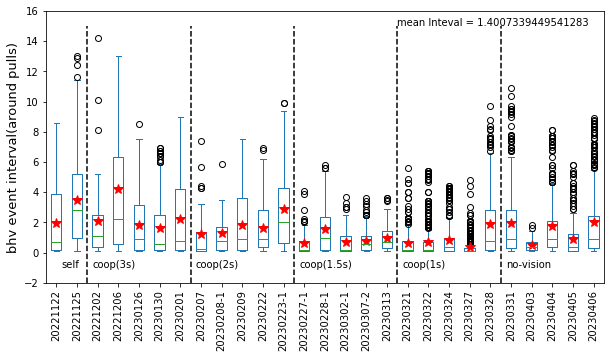

In [84]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-5,15,'mean Inteval = '+str(np.nanmean(pull_other_intv_forplots)),fontsize=10)

print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

### prepare the input data for DBN

In [85]:
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,3,  3,3,5]
DBN_group_coopthres = [0,3,2,1.5,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

prepare_input_data = 0

DBN_input_data_alltypes = dict.fromkeys(DBN_group_typenames, [])

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            
        # get animal info
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()
        
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]
            
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1

        # load behavioral event results
        print('load social gaze with Anipose 3d of '+date_tgt)
        with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
            output_look_ornot = pickle.load(f)
        with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'rb') as f:
            output_allvectors = pickle.load(f)
        with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'rb') as f:
            output_allangles = pickle.load(f)  
        with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'rb') as f:
            output_key_locations = pickle.load(f)     
        look_at_face_or_not_Anipose = output_look_ornot['look_at_face_or_not_Anipose']
        look_at_selftube_or_not_Anipose = output_look_ornot['look_at_selftube_or_not_Anipose']
        look_at_selflever_or_not_Anipose = output_look_ornot['look_at_selflever_or_not_Anipose']
        look_at_othertube_or_not_Anipose = output_look_ornot['look_at_othertube_or_not_Anipose']
        look_at_otherlever_or_not_Anipose = output_look_ornot['look_at_otherlever_or_not_Anipose']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_face_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
        look_at_selflever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selflever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
        look_at_selftube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selftube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
        look_at_othertube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_othertube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
        # 
        look_at_Anipose = {"face":look_at_face_or_not_Anipose,"selflever":look_at_selflever_or_not_Anipose,
                           "selftube":look_at_selftube_or_not_Anipose,"otherlever":look_at_otherlever_or_not_Anipose,
                           "othertube":look_at_othertube_or_not_Anipose}      
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_Anipose(bhv_data,look_at_Anipose)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        timepoint_lever1 = output_time_points_levertube['time_point_lookatlever1']   
        timepoint_lever2 = output_time_points_levertube['time_point_lookatlever2']   
        timepoint_tube1 = output_time_points_levertube['time_point_lookattube1']   
        timepoint_tube2 = output_time_points_levertube['time_point_lookattube2']   


        if mergetempRos:
            temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # use bhv event to decide temporal resolution
            #
            #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)

        ntemp_reses = np.shape(temp_resolus)[0]           

        # try different temporal resolutions
        for temp_resolu in temp_resolus:
            bhv_df = []

            if np.isin(animal1,animal1_fixedorder):
                bhv_df_itr = train_DBN_alec_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                bhv_df_itr = train_DBN_alec_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

            if len(bhv_df)==0:
                bhv_df = bhv_df_itr
            else:
                bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                #bhv_df = bhv_df.reset_index(drop=True)        

            # merge sessions from the same condition
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                # merge sessions 
                if (tasktype!=3):
                    if (tasktype==iDBN_group_typeID):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])
                else:
                    if (coop_thres==iDBN_group_cothres):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])

            # save data
            if 1:
                data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                if not os.path.exists(data_saved_subfolder):
                    os.makedirs(data_saved_subfolder)
                if not mergetempRos:
                    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(DBN_input_data_alltypes, f)
                else:
                    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                        pickle.dump(DBN_input_data_alltypes, f)     

### run the DBN model on the combined session data set

In [86]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 200 # number of random starting points/graphs
nbootstraps = 190

try:
    #dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
       
        if not moreSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            samplingsizes = [min_samplesize,max_samplesize]
            samplingsizes_name = ['min_row_number','max_row_number']   
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_alec
                    colnames = ["pull1_t0","pull2_t0","owgaze1_t0","owgaze2_t0","pull1_t1","pull2_t1","owgaze1_t1","owgaze2_t1"]
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t1')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = nevents
                    nToNodes = nevents

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = num_starting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec_training_only(bhv_df,starting_graph)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec_training_only(bhv_df_shuffle,starting_graph)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:  
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


### plot graphs - plot the two time step separately
#### not use anymore 

In [87]:
if 0:
    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1,1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number','max_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    # make sure these variables are consistent with the train_DBN_alec.py settings
    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
    nevents = np.size(eventnames)
    eventnodes_color = ['b','r','y','g']
    nFromNodes = nevents
    nToNodes = nevents

    savefigs = 1  

    # different session conditions (aka DBN groups)
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try: 
            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            fig, axs = plt.subplots(nsamplings,ntemp_reses)
            fig.set_figheight(5*nsamplings)
            fig.set_figwidth(20)

            # different time bin size
            for ii in np.arange(0,ntemp_reses,1):    

                temp_resolu = temp_resolus[ii]

                # different down/re-sampling size
                for jj in np.arange(0,nsamplings,1):

                    j_sampsize_name = samplingsizes_name[jj]

                    weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
                    sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

                    sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt

                    # plot
                    axs[jj,ii].set_title(iDBN_group_typename+'; '+str(temp_resolu)+'s bin; '+j_sampsize_name)
                    axs[jj,ii].set_xlim([-0.5,1.5])
                    axs[jj,ii].set_xticks([0,1])
                    axs[jj,ii].set_xticklabels(['t_0','t_1'])
                    axs[jj,ii].set_ylim([-1,nevents])
                    axs[jj,ii].set_yticks(np.arange(0,nevents,1))
                    axs[jj,ii].set_yticklabels(eventnames)
                    #axs[jj,ii].spines['top'].set_visible(False)
                    #axs[jj,ii].spines['right'].set_visible(False)
                    #axs[jj,ii].spines['bottom'].set_visible(False)
                    #axs[jj,ii].spines['left'].set_visible(False)

                    for ieventnode in np.arange(0,nevents,1):
                        # plot the event nodes
                        axs[jj,ii].plot(0,ieventnode,'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')
                        axs[jj,ii].plot(1,ieventnode,'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')

                        # plot the event edges
                        for ifromNode in np.arange(0,nFromNodes,1):
                            for itoNode in np.arange(0,nToNodes,1):
                                edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                                if edge_weight_tgt>0:
                                    axs[jj,ii].plot([0,1],[ifromNode,itoNode],'k-',linewidth=edge_weight_tgt*3)

            if savefigs:
                if moreSampSize:
                    figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)
                    plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+iDBN_group_typename+'_moreSampSize.jpg')
                else:
                    figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)
                    plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+iDBN_group_typename+'.jpg')

        except:
            continue


### plot graphs - show the edge with arrows
#### not use anymore

In [88]:
if 0:
    # make sure these variables are the same as in the previous steps
    temp_resolus = [1,1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    # temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number','max_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    # make sure these variables are consistent with the train_DBN_alec.py settings
    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
    eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
    eventname_locations = [[-0.4,1.0],[1.2,1],[-0.5,0],[1.2,0]]
    # indicate where edge starts
    # for the self edge, it's the center of the self loop
    nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                           [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                           [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                           [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
    # indicate where edge goes
    # for the self edge, it's the theta1 and theta2 (with fixed radius)
    nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                            [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                            [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                            [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

    nevents = np.size(eventnames)
    eventnodes_color = ['b','r','y','g']
    nFromNodes = nevents
    nToNodes = nevents

    savefigs = 1

    # different session conditions (aka DBN groups)
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:
            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            fig, axs = plt.subplots(nsamplings,ntemp_reses)
            fig.set_figheight(5*nsamplings)
            fig.set_figwidth(20)

            # different time bin size
            for ii in np.arange(0,ntemp_reses,1):    

                temp_resolu = temp_resolus[ii]

                # different down/re-sampling size
                for jj in np.arange(0,nsamplings,1):

                    j_sampsize_name = samplingsizes_name[jj]

                    weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
                    sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

                    sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt

                    # plot
                    axs[jj,ii].set_title(iDBN_group_typename+'; '+str(temp_resolu)+'s bin; '+j_sampsize_name)
                    axs[jj,ii].set_xlim([-0.5,1.5])
                    axs[jj,ii].set_ylim([-0.5,1.5])
                    axs[jj,ii].set_xticks([])
                    axs[jj,ii].set_xticklabels([])
                    axs[jj,ii].set_yticks([])
                    axs[jj,ii].set_yticklabels([])
                    axs[jj,ii].spines['top'].set_visible(False)
                    axs[jj,ii].spines['right'].set_visible(False)
                    axs[jj,ii].spines['bottom'].set_visible(False)
                    axs[jj,ii].spines['left'].set_visible(False)
                    # axs[jj,ii].axis('equal')

                    for ieventnode in np.arange(0,nevents,1):
                        # plot the event nodes
                        axs[jj,ii].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
                        axs[jj,ii].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                        eventnames[ieventnode],fontsize=10)

                        # plot the event edges
                        for ifromNode in np.arange(0,nFromNodes,1):
                            for itoNode in np.arange(0,nToNodes,1):
                                edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                                if edge_weight_tgt>0:
                                    if not ifromNode == itoNode:
                                        #axs[jj,ii].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                        axs[jj,ii].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                         nodearrow_locations[ifromNode][itoNode][1],
                                                         nodearrow_directions[ifromNode][itoNode][0],
                                                         nodearrow_directions[ifromNode][itoNode][1],
                                                         head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt)
                                    if ifromNode == itoNode:
                                        ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                              .1, nodearrow_directions[ifromNode][itoNode][0],
                                                              nodearrow_directions[ifromNode][itoNode][1], 
                                                              0.04*edge_weight_tgt)
                                        p = PatchCollection(
                                            [ring], 
                                            facecolor='#2693de', 
                                            edgecolor='#000000'
                                        )
                                        axs[jj,ii].add_collection(p)
                                        # add arrow head
                                        if ifromNode < 2:
                                            axs[jj,ii].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                             nodearrow_locations[ifromNode][itoNode][1],
                                                             0,-0.05,fc='#2693de',
                                                             head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt)
                                        else:
                                            axs[jj,ii].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                             nodearrow_locations[ifromNode][itoNode][1],
                                                             0,0.02,fc='#2693de',
                                                             head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt)


            if savefigs:
                if moreSampSize:
                    figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)
                    plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+iDBN_group_typename+'_moreSampSize_onelagplot.jpg')
                else:
                    figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)
                    plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+iDBN_group_typename+'_onelagplot.jpg')

        except:
            continue


### plot graphs - show the edge with arrows; show the best time bin and row number

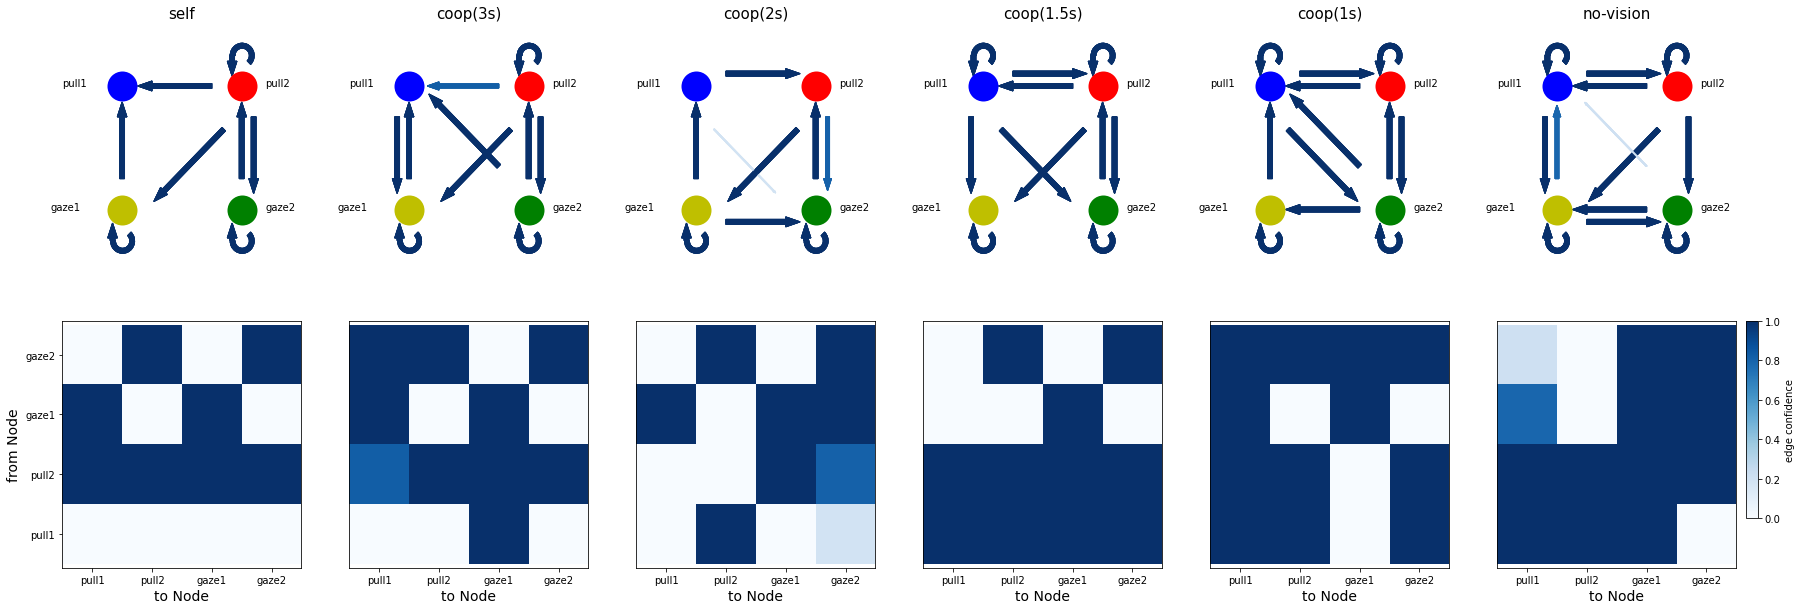

In [89]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2"]
# eventnames = ["M1pull","M2pull","M1gazeM2","M2gazeM1"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
eventnodes_color = ['b','r','y','g']
nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
fig, axs = plt.subplots(2,nDBN_groups)
fig.set_figheight(10)
fig.set_figwidth(30)
    
for iDBN_group in np.arange(0,nDBN_groups,1):
    
    try:

        iDBN_group_typename = DBN_group_typenames[iDBN_group]

        temp_resolu = temp_resolus[0]

        j_sampsize_name = samplingsizes_name[0]

        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
        sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

        sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt

        # plot
        axs[0,iDBN_group].set_title(iDBN_group_typename,fontsize=15)
        axs[0,iDBN_group].set_xlim([-0.5,1.5])
        axs[0,iDBN_group].set_ylim([-0.5,1.5])
        axs[0,iDBN_group].set_xticks([])
        axs[0,iDBN_group].set_xticklabels([])
        axs[0,iDBN_group].set_yticks([])
        axs[0,iDBN_group].set_yticklabels([])
        axs[0,iDBN_group].spines['top'].set_visible(False)
        axs[0,iDBN_group].spines['right'].set_visible(False)
        axs[0,iDBN_group].spines['bottom'].set_visible(False)
        axs[0,iDBN_group].spines['left'].set_visible(False)
        # axs[0,iDBN_group].axis('equal')

        for ieventnode in np.arange(0,nevents,1):
            # plot the event nodes
            axs[0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
            axs[0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                   eventnames[ieventnode],fontsize=10)

            clmap = mpl.cm.get_cmap('Blues')
            
            # plot the event edges
            for ifromNode in np.arange(0,nFromNodes,1):
                for itoNode in np.arange(0,nToNodes,1):
                    edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                    if edge_weight_tgt>0:
                        if not ifromNode == itoNode:
                            #axs[0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                            axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                    nodearrow_locations[ifromNode][itoNode][1],
                                                    nodearrow_directions[ifromNode][itoNode][0],
                                                    nodearrow_directions[ifromNode][itoNode][1],
                                                    head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt,
                                                    color = clmap(edge_weight_tgt))
                        if ifromNode == itoNode:
                            ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                  .1, nodearrow_directions[ifromNode][itoNode][0],
                                                  nodearrow_directions[ifromNode][itoNode][1], 
                                                  0.04*edge_weight_tgt,
                                                  color = clmap(edge_weight_tgt))
                            p = PatchCollection(
                                [ring], 
                                facecolor=clmap(edge_weight_tgt), 
                                edgecolor=clmap(edge_weight_tgt)
                            )
                            axs[0,iDBN_group].add_collection(p)
                            # add arrow head
                            if ifromNode < 2:
                                axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        0,-0.05,color=clmap(edge_weight_tgt),
                                                        head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt)
                            else:
                                axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        0,0.02,color=clmap(edge_weight_tgt),
                                                        head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt)

        # heatmap for the weights
        sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
        sig_avg_dags_df.columns = eventnames
        sig_avg_dags_df.index = eventnames
        vmin,vmax = 0,1
        import matplotlib as mpl
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        im = axs[1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Blues",norm=norm)
        #
        if iDBN_group == nDBN_groups-1:
            cax = axs[1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
            fig.colorbar(im, ax=axs[1,iDBN_group], cax=cax,label='edge confidence')

        axs[1,iDBN_group].axis('equal')
        axs[1,iDBN_group].set_xlabel('to Node',fontsize=14)
        axs[1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
        axs[1,iDBN_group].set_xticklabels(eventnames)
        if iDBN_group == 0:
            axs[1,iDBN_group].set_ylabel('from Node',fontsize=14)
            axs[1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
            axs[1,iDBN_group].set_yticklabels(eventnames)
        else:
            axs[1,iDBN_group].set_yticks([])
            axs[1,iDBN_group].set_yticklabels([])
                                     
    except:
        continue
    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.jpg')
    else:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.jpg')
            
            
            

### plot graphs - show the edge with arrows; show the best time bin and all the row numbers

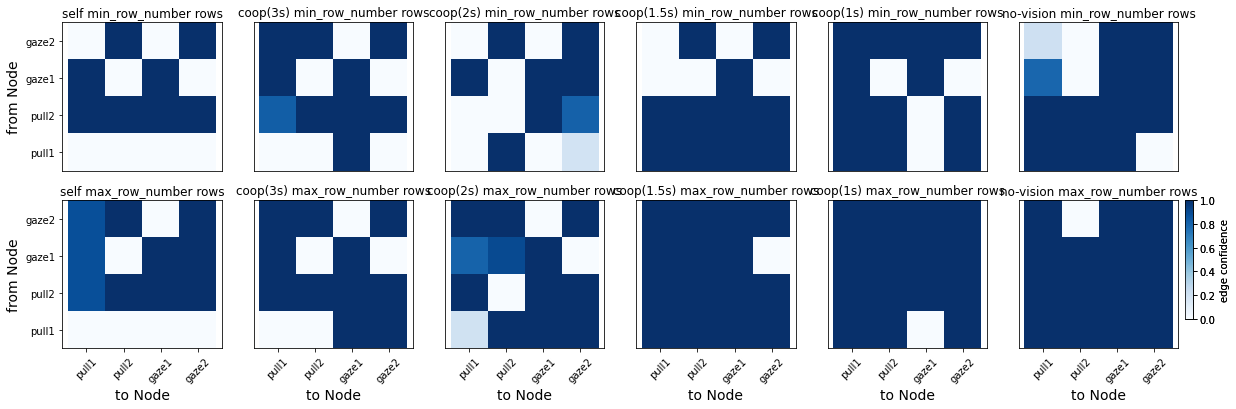

In [90]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    samplingsizes = np.arange(1100,3000,100)
    # samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number','max_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]


# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2"]
# eventnames = ["M1pull","M2pull","M1gazeM2","M2gazeM1"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
eventnodes_color = ['b','r','y','g']
nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
fig, axs = plt.subplots(nsamplings,nDBN_groups)
fig.set_figheight(3*nsamplings)
fig.set_figwidth(20)
    
temp_resolu = temp_resolus[0]    
    
# different time bin size
for ii in np.arange(0,nsamplings,1):    

    j_sampsize_name = samplingsizes_name[ii]   
    
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]        

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt

            # plot
            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ii,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Blues",norm=norm)
            #
            if iDBN_group == nDBN_groups-1:
                cax = axs[1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[1,iDBN_group], cax=cax,label='edge confidence')

            axs[ii,iDBN_group].axis('equal')
            axs[ii,iDBN_group].set_title(iDBN_group_typename+' '+j_sampsize_name+' rows')
            if ii == nsamplings-1:
                axs[ii,iDBN_group].set_xlabel('to Node',fontsize=14)
                axs[ii,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
                axs[ii,iDBN_group].set_xticklabels(eventnames,rotation=45)
            else:
                axs[ii,iDBN_group].set_xticklabels([])
                axs[ii,iDBN_group].set_xticks([])
                
            if iDBN_group == 0:
                axs[ii,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ii,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ii,iDBN_group].set_yticklabels(eventnames)
            else:
                axs[ii,iDBN_group].set_yticks([])
                axs[ii,iDBN_group].set_yticklabels([])

        except:
            continue
    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_multirows.jpg')
    else:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxrows.jpg')
            
            
            

### plot graphs - show the edge differences, use one condition as the base

/tmp/ipykernel_1966617/2913247342.py:75: RuntimeWarning: invalid value encountered in true_divide
  sig_avg_dags = sig_avg_dags/(weighted_graphs_tgt.mean(axis = 0) + weighted_graphs_base )


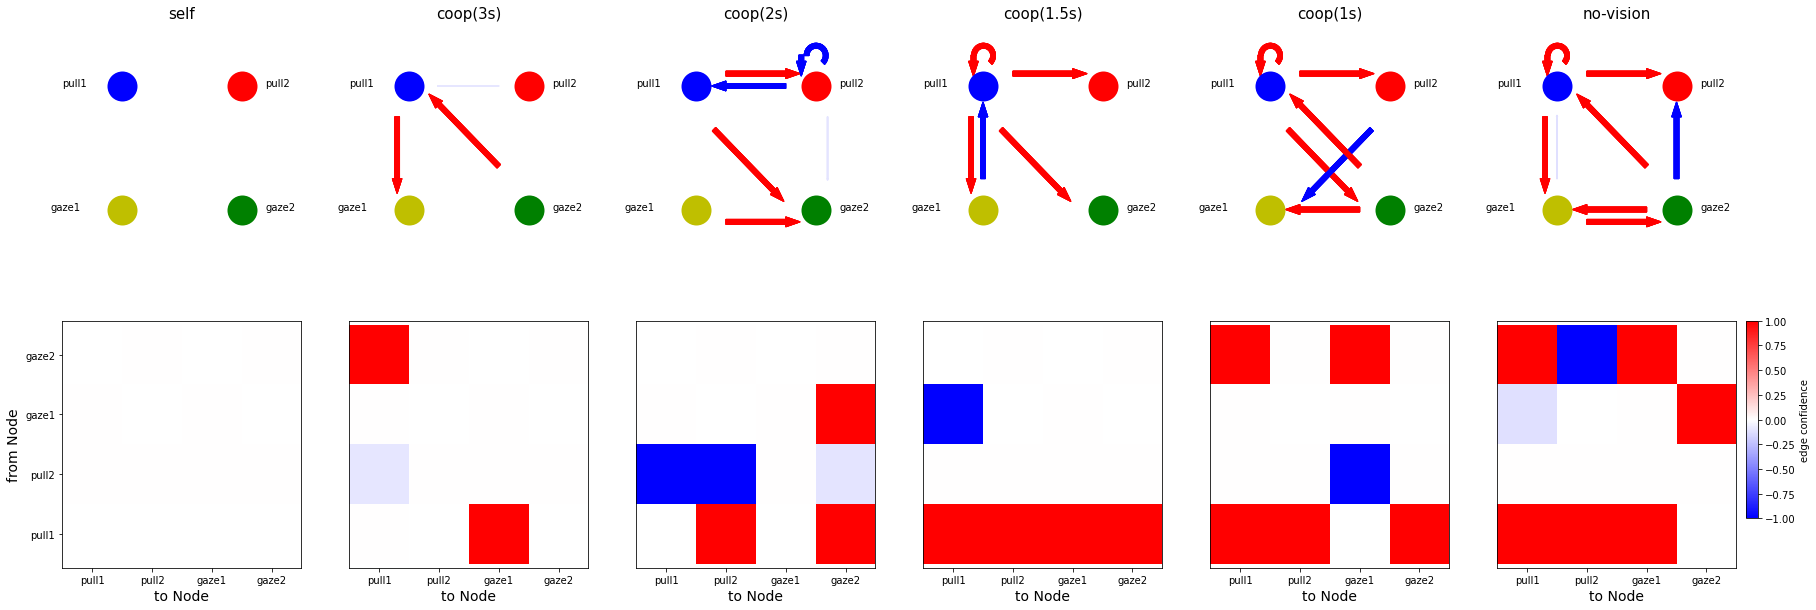

In [94]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

basecondition = 'self'

# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2"]
# eventnames = ["M1pull","M2pull","M1gazeM2","M2gazeM1"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
eventnodes_color = ['b','r','y','g']
nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
fig, axs = plt.subplots(2,nDBN_groups)
fig.set_figheight(10)
fig.set_figwidth(30)
    
temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    
    
weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]

weighted_graphs_base = weighted_graphs_tgt.mean(axis = 0)
sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base * sig_edges_base  
    
for iDBN_group in np.arange(0,nDBN_groups,1):
    
    try:

        iDBN_group_typename = DBN_group_typenames[iDBN_group]        

        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
        sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

        sig_edge_either = ((sig_edges_tgt+sig_edges_base)>0)*1
            
        sig_avg_dags = (weighted_graphs_tgt.mean(axis = 0) - weighted_graphs_base)*sig_edge_either

        try:
            sig_avg_dags = sig_avg_dags/(weighted_graphs_tgt.mean(axis = 0) + weighted_graphs_base )
        except:
            sig_avg_dags =  sig_avg_dags

        # plot
        axs[0,iDBN_group].set_title(iDBN_group_typename,fontsize=15)
        axs[0,iDBN_group].set_xlim([-0.5,1.5])
        axs[0,iDBN_group].set_ylim([-0.5,1.5])
        axs[0,iDBN_group].set_xticks([])
        axs[0,iDBN_group].set_xticklabels([])
        axs[0,iDBN_group].set_yticks([])
        axs[0,iDBN_group].set_yticklabels([])
        axs[0,iDBN_group].spines['top'].set_visible(False)
        axs[0,iDBN_group].spines['right'].set_visible(False)
        axs[0,iDBN_group].spines['bottom'].set_visible(False)
        axs[0,iDBN_group].spines['left'].set_visible(False)
        # axs[0,iDBN_group].axis('equal')

        for ieventnode in np.arange(0,nevents,1):
            # plot the event nodes
            axs[0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
            axs[0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                   eventnames[ieventnode],fontsize=10)

            clmap = mpl.cm.get_cmap('bwr')
            
            # plot the event edges
            for ifromNode in np.arange(0,nFromNodes,1):
                for itoNode in np.arange(0,nToNodes,1):
                    edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                    if edge_weight_tgt!=0:
                        if not ifromNode == itoNode:
                            #axs[0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                            axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                    nodearrow_locations[ifromNode][itoNode][1],
                                                    nodearrow_directions[ifromNode][itoNode][0],
                                                    nodearrow_directions[ifromNode][itoNode][1],
                                                    head_width=0.08*abs(edge_weight_tgt),
                                                    width=0.04*abs(edge_weight_tgt),
                                                    color=clmap((1+edge_weight_tgt)/2))
                        if ifromNode == itoNode:
                            ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                  .1, nodearrow_directions[ifromNode][itoNode][0],
                                                  nodearrow_directions[ifromNode][itoNode][1], 
                                                  width=0.04*abs(edge_weight_tgt),
                                                  color=clmap((1+edge_weight_tgt)/2))
                            p = PatchCollection(
                                [ring], 
                                facecolor=clmap((1+edge_weight_tgt)/2), 
                                edgecolor=clmap((1+edge_weight_tgt)/2)
                            )
                            axs[0,iDBN_group].add_collection(p)
                            # add arrow head
                            if ifromNode < 2:
                                axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        0,-0.05,color=clmap((1+edge_weight_tgt)/2),
                                                        head_width=0.08*abs(edge_weight_tgt),
                                                        width=0.04*abs(edge_weight_tgt))
                            else:
                                axs[0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        0,0.02,color=clmap((1+edge_weight_tgt)/2),
                                                        head_width=0.08*abs(edge_weight_tgt),
                                                        width=0.04*abs(edge_weight_tgt))

        # heatmap for the weights
        sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
        sig_avg_dags_df.columns = eventnames
        sig_avg_dags_df.index = eventnames
        vmin,vmax = -1,1
        import matplotlib as mpl
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        im = axs[1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
        #
        if iDBN_group == nDBN_groups-1:
            cax = axs[1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
            fig.colorbar(im, ax=axs[1,iDBN_group], cax=cax,label='edge confidence')

        axs[1,iDBN_group].axis('equal')
        axs[1,iDBN_group].set_xlabel('to Node',fontsize=14)
        axs[1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
        axs[1,iDBN_group].set_xticklabels(eventnames)
        if iDBN_group == 0:
            axs[1,iDBN_group].set_ylabel('from Node',fontsize=14)
            axs[1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
            axs[1,iDBN_group].set_yticklabels(eventnames)
        else:
            axs[1,iDBN_group].set_yticks([])
            axs[1,iDBN_group].set_yticklabels([])
                                     
    except:
        continue
    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.jpg')
    else:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.jpg')
            
            
            

### plot graphs - show the edge differences, use one condition as the base; show multiple row numbers (one time bin)

/tmp/ipykernel_1966617/997397885.py:79: RuntimeWarning: invalid value encountered in true_divide
  sig_avg_dags = sig_avg_dags/(weighted_graphs_tgt.mean(axis = 0) + weighted_graphs_base )


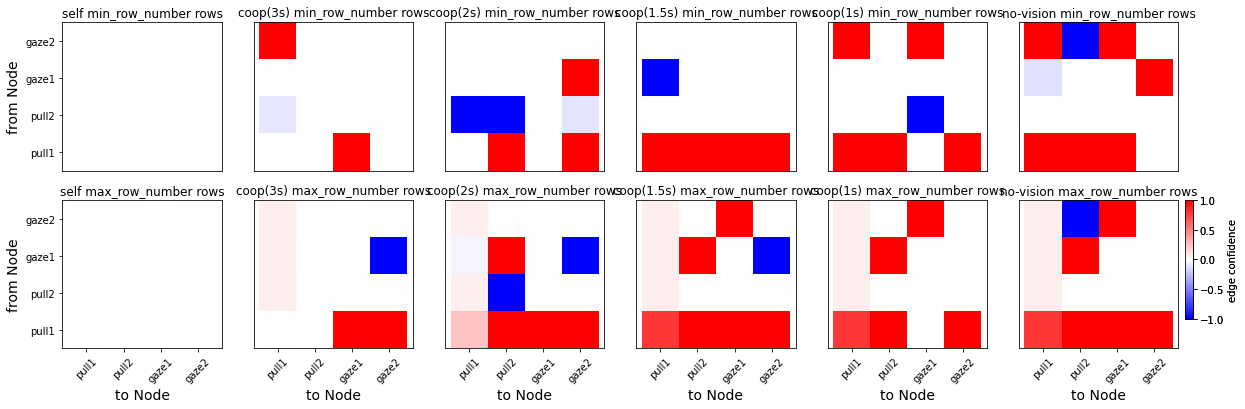

In [98]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    samplingsizes = np.arange(1100,3000,100)
    # samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number','max_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

basecondition = 'self'

# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2"]
# eventnames = ["M1pull","M2pull","M1gazeM2","M2gazeM1"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
eventnodes_color = ['b','r','y','g']
nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
fig, axs = plt.subplots(nsamplings,nDBN_groups)
fig.set_figheight(3*nsamplings)
fig.set_figwidth(20)
    
temp_resolu = temp_resolus[0]    
    
# different time bin size
for ii in np.arange(0,nsamplings,1):    

    j_sampsize_name = samplingsizes_name[ii]   
    
    weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
    sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
    
    weighted_graphs_base = weighted_graphs_tgt.mean(axis = 0)
    sig_edges_base = sig_edges_tgt

    sig_avg_dags_base =  weighted_graphs_base * sig_edges_base 
    
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]        

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

            sig_edge_either = ((sig_edges_tgt+sig_edges_base)>0)*1
            
            sig_avg_dags = (weighted_graphs_tgt.mean(axis = 0) - weighted_graphs_base)*sig_edge_either

            try:
                sig_avg_dags = sig_avg_dags/(weighted_graphs_tgt.mean(axis = 0) + weighted_graphs_base )
            except:
                sig_avg_dags =  sig_avg_dags

            # plot
            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = -1,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ii,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
            #
            if iDBN_group == nDBN_groups-1:
                cax = axs[1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[1,iDBN_group], cax=cax,label='edge confidence')
                
            if iDBN_group == 0:
                axs[ii,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ii,iDBN_group].set_yticks(np.arange(0.5,4.5,1))     
                axs[ii,iDBN_group].set_yticklabels(eventnames)
            else:
                axs[ii,iDBN_group].set_yticks([])
                axs[ii,iDBN_group].set_yticklabels([])
            

            axs[ii,iDBN_group].axis('equal')
            axs[ii,iDBN_group].set_title(iDBN_group_typename+' '+j_sampsize_name+' rows')
            if ii == nsamplings-1:
                axs[ii,iDBN_group].set_xlabel('to Node',fontsize=14)
                axs[ii,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
                axs[ii,iDBN_group].set_xticklabels(eventnames,rotation=45)
            else:
                axs[ii,iDBN_group].set_xticklabels([])
                axs[ii,iDBN_group].set_xticks([])
            
            
            

        except:
            continue
    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_multirows_EdgeFifferenceFrom_'+basecondition+'AsBase.jpg')
    else:
        figsavefolder = data_saved_folder+'figs_for_DBN_and_bhv_Aniposelib3d_combinesessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"oneTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxrows_EdgeFifferenceFrom_'+basecondition+'AsBase.jpg')
            
            
            